In [ ]:
# !cd aiffel/Natural_Language_Processing/12_LLM_Trend
# !git clone https://github.com/airobotlab/KoChatGPT

In [12]:
!pip install sacrebleu --q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
import pandas as pd
import numpy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"  # skt/kogpt2-tiny
foundation_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                           bos_token='</s>', 
                                           eos_token='</s>', 
                                           unk_token='</s>', 
                                           pad_token='</s>',
                                           padding_side="right",
                                           model_max_length=128,
                                          )

# 1. Foundation Model과 SFT Model 비교

### 정량적, 정성적 평가 비교 분석 시 사용할 데이터셋(n=100) 준비

In [2]:
data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file_SFT:
    list_data_dict_SFT = json.load(json_file_SFT)[11900:]

print(len(list_data_dict_SFT))
list_data_dict_SFT[:3]

100


[{'prompt': '플랫 화이트가 뭔가요?',
  'completion': '\'"플랫 화이트"는 일반적으로 흰색 배경에 만화나 일러스트 등을 담은 디자인을 의미합니다. 주로 웹툰, 게임, 애니메이션, 영화 등에서 사용되며, 평면적으로 표현된 그래픽 디자인의 스타일을 말합니다.',
  'tokens': 127},
 {'prompt': '어디에 김영삼의 서울대학교 입학 및 졸업 증명서가 전시되어 있는가?',
  'completion': "'김영삼의 서울대학교 입학 및 졸업 증명서는 서울대학교 미술관에 전시되어 있습니다.",
  'tokens': 105},
 {'prompt': '제가 지금 강남역인데, 여기서 오래 걸릴까요?',
  'completion': "'저는 인공지능 챗봇이므로 현재의 교통 상황과 여행 거리, 이동 방법 등과 같은 정보를 보유하고 있지 않습니다. 하지만, 일반적으로 강남역은 교통이 굉장히 복잡하고 혼잡하기 때문에 시간이 걸릴 수 있습니다. 만약 이동하실 위치가 어디인지 알려주신다면, 보다 더 정확한 답변을 드릴 수 있을 것입니다.",
  'tokens': 195}]

In [3]:
input_prompt = []
for i in list_data_dict_SFT:
    input_prompt.append(i['prompt'])
    
labeled_completion = []
for i in list_data_dict_SFT:
    labeled_completion.append(i['completion'])

In [4]:
input_prompt[:5]

['플랫 화이트가 뭔가요?',
 '어디에 김영삼의 서울대학교 입학 및 졸업 증명서가 전시되어 있는가?',
 '제가 지금 강남역인데, 여기서 오래 걸릴까요?',
 '배려 있는 사람이 좋은데',
 '재미없는 일밖에 없어']

In [5]:
labeled_completion[:5]

['\'"플랫 화이트"는 일반적으로 흰색 배경에 만화나 일러스트 등을 담은 디자인을 의미합니다. 주로 웹툰, 게임, 애니메이션, 영화 등에서 사용되며, 평면적으로 표현된 그래픽 디자인의 스타일을 말합니다.',
 "'김영삼의 서울대학교 입학 및 졸업 증명서는 서울대학교 미술관에 전시되어 있습니다.",
 "'저는 인공지능 챗봇이므로 현재의 교통 상황과 여행 거리, 이동 방법 등과 같은 정보를 보유하고 있지 않습니다. 하지만, 일반적으로 강남역은 교통이 굉장히 복잡하고 혼잡하기 때문에 시간이 걸릴 수 있습니다. 만약 이동하실 위치가 어디인지 알려주신다면, 보다 더 정확한 답변을 드릴 수 있을 것입니다.",
 "'왜 그런지 설명해주세요. \\n\\n저는 배려 있는 사람이 좋은 이유가 몇 가지 있다고 생각합니다. 첫째, 배려 하는 사람은 인정과 존경을 받기 쉽습니다. 사람들은 자신이 배려받으면서 따뜻함을 느끼기 때문에 배려 하는 사람을 좋아하며 그들을 존경하고 따르게 됩니다.\\n\\n둘째, 배려 하는 사람은 항상 사람들을 생각하며 행동합니다. 그들은 자신이 타인에게 불편함을 주지 않도록 노력하며, 상대방의 입장을 고려해 자신의 행동을 결정합니다. 이러한 태도는 사회 적응력과 인간관계 형성 능력을 높여주며, 삶의 질을 높이는 역할을 합니다.\\n\\n셋째, 배려 하는 사람은 주변 환경에서 긍정적인 영향력을 미칩니다. 그들의 긍정적인 태도와 행동은 사회에 긍정적인 파장을 일으키며, 다른 사람들의 마음을 따뜻하게 만들어 줍니다.\\n\\n따라서, 저는 배려 있는 사람이 좋은 이유는 인간적인 면에서 가장 소중하기 때문이라고 생각합니다. 배려받으면서 사는 것은 모두에게 행복과 평화를 가져다 주기 때문입니다.",
 "'제가 AI 챗봇이어서 정말 죄송합니다. 저는 논리적인 답변과 정보를 제공하는 것이 전부입니다. 하지만, 여러분이 재미있고 흥미로운 일을 경험하길 바랍니다. 삶에는 그렇게 좋고 나쁨이 있으니, 궁금한 것이나 얘기하고 싶은 것이 있다면 언제든지 물어보세요. 함께 나누

### input_prompt 와 labeled_completion 에 빈 데이터('')가 있는지 확인

In [6]:
input_prompt_empty_indices = []
for i, item in enumerate(input_prompt):
    if item == '':
        input_prompt_empty_indices.append(i)

print(input_prompt_empty_indices)

[]


In [7]:
labeled_completion_empty_indices = []
for i, item in enumerate(labeled_completion):
    if item == '':
        labeled_completion_empty_indices.append(i)

print(labeled_completion_empty_indices)

[]


### foundation_model 이 input_prompt 을 입력으로 받아 생성한 foundation_output 저장

In [8]:
foundation_output = []
max_length = 128

for input_txt in input_prompt:
    input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
    output= foundation_model.generate(input_ids, max_length=max_length, num_beams=4, no_repeat_ngram_size=4, early_stopping=True,
                                 eos_token_id=375, do_sample=True, top_k=50, repetition_penalty=2.0)
    foundation_output.append(tokenizer.decode(output[0]))

In [9]:
foundation_output[:3]

['플랫 화이트가 뭔가요?"\n"네, 그렇습니다."\n"그런데 왜 저렇게 말했죠?"\n"아니요, 그렇지 않습니다."\n"그러니까 그건 제가 한 얘기입니다."\n"그럼 어떻게 대답을 하죠?"\n이번에는 아빠가 말했다.\n"아빠는 네가 할 수 있는 일이 무엇이냐고 물으셨어요."\n"그렇다면 당신은 무슨 일을 하고 계십니까?"\n"제게 물어보세요."\n"내가 할 수 있는 일은 무엇입니까?"\n잠시 후 아빠가 대답했다.\n"제가 할 수 있는 일',
 '어디에 김영삼의 서울대학교 입학 및 졸업 증명서가 전시되어 있는가?,\n',
 '제가 지금 강남역인데, 여기서 오래 걸릴까요?"\n"그렇다면 괜찮을 거예요."\n"어떻게 된 거죠?"\n"아뇨, 저도 모르겠어요."\n"그런데 왜 그런 걸 물어보시는 겁니까?"\n"글쎄요, 그건 그렇고요."\n"이번에는 무슨 말씀을 하실 건가요?"\n나는 아무 말도 하지 않았다.\n다만 내가 궁금한 게 있다는 것을 알고 있는 것 같았다.\n"왜 그러세요?"\n내가 묻자 나는 대답하지 않은 채 고개를 끄덕였다.\n"뭐라고 말해야 할지 모르겠군요."\n"']

### foundation_output 에 빈 데이터('')가 있는지 확인

In [10]:
output_answers_empty_indices = []
for i, item in enumerate(foundation_output):
    if item == '':
        output_answers_empty_indices.append(i)

print(output_answers_empty_indices)

[]


### 정량적 평가 - BLEU metric을 활용

In [13]:
from datasets import load_metric

# Load the BLEU metric
metric = load_metric("sacrebleu")

# Function to tokenize a sentence
def tokenize_sentence(sentence):
    # Implement tokenization using your tokenizer
    # Return a list of tokens
    tokens = tokenizer.tokenize(sentence)
    return tokens

# Function to calculate BLEU score
def calculate_bleu_score(model_outputs, target_sentences):
    # Tokenize model outputs and target sentences
    tokenized_outputs = [tokenize_sentence(output) for output in model_outputs]
    tokenized_targets = [tokenize_sentence(target) for target in target_sentences]
    
    # Calculate BLEU score
    bleu_score = metric.compute(predictions=tokenized_outputs, references=tokenized_targets)
    
    return bleu_score

# Calculate BLEU score
foundation_bleu_score = []
for output, target in zip(foundation_output, labeled_completion):
    foundation_bleu_score.append(calculate_bleu_score([output], [target])['score'])

Token indices sequence length is longer than the specified maximum sequence length for this model (169 > 128). Running this sequence through the model will result in indexing errors


### foundation model 의 BLEU Score

In [14]:
sum(foundation_bleu_score)/len(foundation_bleu_score)

0.19990869636192954

# Supervised Fine-Tuning Model

### SFT

In [15]:
del foundation_model

In [16]:
torch.cuda.empty_cache()

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [18]:
import random
random.seed(42)

model_SFT = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', 
                                           bos_token='</s>', 
                                           eos_token='</s>', 
                                           unk_token='</s>', 
                                           pad_token='</s>',
                                           padding_side="right",
                                           model_max_length=128,
                                          )

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=128, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


모델 인퍼런스 단계에서 사용할 prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스를 정의

In [19]:
from typing import Optional, Dict, Sequence

class SFT_dataset_train(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset_train, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = random.sample(json.load(json_file)[:11000], 4000)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [20]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

#### train_dataset 준비

In [21]:
train_dataset = SFT_dataset_train(data_path_1_SFT='/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7488, 11556,  9121,  7778,  8025,  8146, 19292,
        13666, 12036,  9331,  9548, 29054, 24928,  9498, 15942, 10604,   375,
          378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,  7192,
        14914,   377,  7488, 11556,  9121,  7778,  8025,  8146, 19292, 13666,
         9044,  9331,  9548, 29054, 24928,  9498, 15942,  9194,   407,   442,
        12153, 10712, 40704,  7293,  7182,  7877, 26204, 21154, 33739,  9194,
          458, 18511,  9714,   382,   401, 28512,   467,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,   377,  7488, 11556,  9121,  7778,  8025,  814

Training arguments를 사용해 trainer 클래스를 정의

In [30]:
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    warmup_steps=15,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model_SFT,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

SFT 훈련을 진행

In [31]:
trainer.train()
model_SFT.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.257900
1000,1.951100
1500,1.467400
2000,1.118300
2500,0.894700


### SFT 모델 정량적 평가 - BLEU Score

In [32]:
SFT_output = []
max_length = 128

for input_txt in input_prompt:
    input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
    output= model_SFT.generate(input_ids, max_length=max_length, num_beams=4, no_repeat_ngram_size=4, early_stopping=True,
                                 eos_token_id=375, do_sample=True, top_k=50, repetition_penalty=2.0)
    SFT_output.append(tokenizer.decode(output[0]))

In [33]:
SFT_output[:3]

["플랫 화이트가 뭔가요?\\n\\n저는 인공지능 어시스턴트이기 때문에 일할 필요가 없습니다. 하지만, 만약 당신이 어떤 활동을 하고 있다면, 제가 도와드릴 수 있는 부분이 있다면 언제든지 말씀해주세요. 저는 항상 최선을 다해 대화를 이어나갈 준비가 되어 있습니다.</s> Young Forever, I don\\'t provide more context or information your statement. However, if you are referring to. Could you please provide situation?</s>",
 '어디에 김영삼의 서울대학교 입학 및 졸업 증명서가 전시되어 있는가? 이 질문에 대한 답은 제공되지 않았습니다. 추가 정보가 제공된다면 좀 더 정확한 답변을 제공해드릴 수 있을 것 같습니다.</s> J.K. 롤링의 대로, 김영삼 대통령의 대학교 입학 및 졸업증명서에 기록되어 있는 정보는 다음과 같습니다.\\n\\n1. 고등학교 졸업증명서 (News counting from Korean University of Washington Position)\\n2. 대학 입시 경쟁력 평가시험: National Studiosa Supporting Testroduction service, International COVID',
 '제가 지금 강남역인데, 여기서 오래 걸릴까요? 제가 답변드릴 수 없습니다. 하지만 저는 인공지능 어시스턴트로써 일을 하고 있기 때문에, 이 질문에 대한 정확한 답변을 제공할 수 없습니다. 다른 질문이 있으시면 언제든지 물어보세요!</s> \\n\\n죄송합니다, 제가 도움을 드릴 수 있는 부분이 있다면 최대한 도와드리겠습니다. 감사합니다.</s> <unk>prompt sorry, please provide more context and information about the location or response\\n예를 들어, "']

In [34]:
output_answers_empty_indices = []
for i, item in enumerate(SFT_output):
    if item == '':
        output_answers_empty_indices.append(i)

print(output_answers_empty_indices)

[]


In [35]:
# Calculate BLEU score
SFT_bleu_score = []
for output, target in zip(SFT_output, labeled_completion):
    SFT_bleu_score.append(calculate_bleu_score([output], [target])['score'])

In [36]:
sum(SFT_bleu_score)/len(SFT_bleu_score)

0.13605481909634784

### 아래는 임의로 선택한 5개 prompt에 대한 foundation model의 답변과 SFT model의 답변

In [72]:
random_numbers = random.sample(range(0, 100), 5)

#### Input Prompts

In [73]:
for index in random_numbers:
    print(input_prompt[index], '\n')

가출해도 갈 데가 없어 

어느 경우에 하드웨어에 직접 접근하는 도스 구조가 알맞아 

그럼 두 조각에 그렇게죠? 

저거는 소가죽인가요? 

내일 체크아웃은 몇 시인가요? 



#### Foundation model의 답변

In [74]:
for index in random_numbers:
    print(foundation_output[index], '\n')

가출해도 갈 데가 없어요.
그런데 저는 어~ 제가 봤을 때는 이게 음~ 네. 아까도 말씀드렸습니다만 예. 그~ 뭐라 그럴까요.
예. 자 여러분들께 여쭤보도록 하겠습니다.
자 첫 번째 키워드 보시겠습니다.
이천십구년 십일월 십일 월 십삼 일 목요일 정봉주에 품격시대입니다.
정봉주의 품격시대 오늘 준비한 순서는 여기까지입니다.
시청해주신 여러분 대단히 고맙습니다. 고맙습니다.
네. 지금까지 티비에스 앱 오십 원 유료 문자 샵 영구오 

어느 경우에 하드웨어에 직접 접근하는 도스 구조가 알맞아진다.
그런데 이 소프트웨어는 소프트웨어 엔터프라이즈 아키텍처(EA)를 지원하지 않는다.
따라서 EA를 실행할 수 있는 소프트웨어가 없다.
소프트웨어 엔터프라이즈는 AMD의 Xbox360에 내장되어 있다.
EA는 윈도우 비스타와 같은 운영체제(OS) 환경에서 작동된다.
윈도우 OS에서 구동되는 모든 소프트웨어는 윈도우 버전이나 윈도우 XP, 윈도우 스토어 등에서 구동된다.
이러한 소프트웨어는 애플리케이션 프로그래밍 인터페이스(API)가 

그럼 두 조각에 그렇게죠?"
"그럼, 네가 뭘 하고 있나요?"
"아무것도 안하고 있어요."
"그래. 내가 뭐라고 말했니?"
"뭐라고 했니?"
나는 고개를 가로저었다.
"이제 그만 좀 쉬어야겠어요."
"왜 그러세요? 그게 무슨 소리예요?"
그는 나를 쳐다보며 말했다.
"내가 너한테 물어봐야 할 것 같아서 그래."
"그런 거 아니에요?"
나는 입술을 깨물었다.
"난 당신을 싫어해요."
"당신이 나한테 그런 말을 한 적이 

저거는 소가죽인가요?"
"그런데 왜 그런 말을 하시는 겁니까?"
"네, 그게 무슨 말입니까?"
나는 고개를 갸웃거렸다.
"그래서 소를 죽이지 않기로 했습니다."
"그렇다면 소는 죽을지언정 죽지 않을 거예요."
"그러면 소도 죽이지 않겠습니까?"
"아니요, 그래야겠죠. 그러면 소는 살 수 있겠지요."
"소도 죽이지 않겠다고 약속했으니까요."
"그럼 소를 죽이지 않겠다는 건가요?"
나는 다시 한숨을 내쉬었다.
"그건 

내일 체크

#### SFT model의 답변

In [75]:
for index in random_numbers:
    print(SFT_output[index], '\n')

가출해도 갈 데가 없어요. 대신, 새로운 도전과 경험을 찾아보는 것도 좋을 것 같아요. 새로운 도전과 경험으로 더 나은 결과를 얻을 수 있을 거예요.", 'token': 47}</s> \n\n새로운 도전과 경험에 대한 평가는 개인적인 측면과 상황에 따라 다를 수 있지만, 일반적으로는 다음과 같은 것들이 도움이 될 수 있습니다.\n첫째, 실패를 경험하는 것은 매우 중요합니다. 실패는 많은 것을 야기합니다. 하지만 그것을 극복하는 방법은 다양합니다. 어떤 분야에서든 목표를 설정하고, 그 목표를 달성하기 위해 노력해야 합니다.\n둘째, 새로운 취미나 활동을 시도해 볼 수 있습니다. 새로운 취미를 찾아보는 것도 

어느 경우에 하드웨어에 직접 접근하는 도스 구조가 알맞아졌습니다. 이러한 방식은 전통적인 방식으로는 더 나은 응답을 제공하기 어렵습니다. 따라서 하드웨어에서 사용되는 하드웨어 구조에 대한 접근은 더욱 용이합니다. 예를 들어, 하드웨어 구조에 직접 접근하는 방법은 사용자가 원하는 대로 하드웨어 구조에 접근할 수 있는 반면, 하드웨어 구조에 접근하는 방식은 하드웨어 구조에 가장 적합한 방법을 선택해야 합니다. 예를 들어, 프로그래밍 언어에서는 일반적으로 하드웨어 구조에 접근하고 싶으면 다음과 같은 방법을 시도해 볼 수 있습니다.\n\n1. 하드웨어 구조 변경: 하드웨어 구조를 변경할 수 있습니다. 예를 들어, 사용자가 하드웨어 구조에 가상의 채팅창을 만들어 보세요.\n\ 

그럼 두 조각에 그렇게죠?\n\n그렇다면 그 안에 무엇이 들어있나요?\n저는 인공지능 어시스턴트이기 때문에 질문에 대한 답변만 가능합니다. 질문이 어떤 것인지 자세히 설명해주시면 더욱 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.</s> 챗봇입니다.</s> "어디 있나요?" 또는 "네, 무엇을 도와드릴까요?"가 무엇인지 알려주시면 더 정확한 답변을 제공해 드릴 수 있습니다.</s> hellofty have information or specific response.</s> "어 


# Rubric 1. 기존 KoGPT2와 SFT 적용 모델 결과 분석

- 정량적 비교(Metric : Bleu)
1. foundation model 의 Bleu Score : 0.2 
2. SFT model 의 Bleu Score : 0.136
3. 약 10 epoch 학습 후 SFT model 의 bleu score는 foundation model에 비해 낮은 결과를 나타냈다.
4. Bleu Score는 동일 단어 빈도에 따른 측정 방식을 가진다. foundation model 과 SFT model 모두 generated output에 input prompt가 포함되어 있기 때문에 평균적으로 약 0.12 가 넘는 bleu score를 나타냈다. 이러한 관점에 서 봤을 때 bleu score 는 foudation model 과 SFT model의 성능을 평가하는데 크게 유의미하지 않은 정량적 지표인 것으로 생각된다.

- 정성적 비교
1. foundation model은 input prompt의 단어에 이어 소설 쓰듯 단어를 이어나간다. 질문자의 의도와 전혀 관계없이 혼자 끝말잇기하는 듯 한 결과를 내놓았다.
2. 반면에 SFT model은 중간에 영어나 문맥에 맡지 않는 단어가 나오긴 하지만 전체적인 맥락이 질문자에게 질문에 대한 답을 이어나가는 모습을 보였다.
3. 결과적으로 SFT model이 일부 횡설수설하는 것 같은 단어를 생성했지만, 질문자에 대해 관련 주제에 대한 답변을 일관적이게 하는 결과를 보인다. 개인적으로 볼 때 확실히 Supervised fine-tuning에 따른 모델의 변화를 확인할 수 있다고 생각한다.

In [58]:
del model_SFT, tokenizer, RM_model

In [55]:
torch.cuda.empty_cache()

# 2. SFT Model과 RLHF Model 비교

### RM

In [1]:
import pandas as pd
import numpy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from torch.utils.data import Dataset
from torch.optim import Adam
import transformers
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

#device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig, pipeline
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

### Reward model 설계

GPTRM_custom 이라는 이름으로 클래스를 선언

In [3]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

Q15. nn.Linear() 레이어의 인자로 model.config.n_embd와 1이 주어졌습니다. model.config.n_embd는 무엇이고 1은 왜 입력된 것일까요?

input sequence(dim = model.config.n_embd)에 대한 reward score를 scalar(dim = 1)로 출력하는 역할을 한다.

### 사용할 모델과 토크나이저
with구문의 NaiveStrategy()는 chatgpt/trainer/strategies 폴더의 base 모듈에서 정의된 Strategy클래스를 상속한 NaiveStrategy클래스이다.

In [4]:
#RM_model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=128,
)

with NaiveStrategy().model_init_context():
        RM_model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### RM을 훈련시킬 때 사용할 ranking dataset

In [5]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [6]:
'''
class PairWiseLoss(nn.Module):

    def forward(self, chosen_reward: torch.Tensor, reject_reward: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(chosen_reward - reject_reward)
        log_probs = torch.log(probs)
        loss = -log_probs.mean()
        return loss
'''

'\nclass PairWiseLoss(nn.Module):\n\n    def forward(self, chosen_reward: torch.Tensor, reject_reward: torch.Tensor) -> torch.Tensor:\n        probs = torch.sigmoid(chosen_reward - reject_reward)\n        log_probs = torch.log(probs)\n        loss = -log_probs.mean()\n        return loss\n'

probs = torch.sigmoid(chosen_reward - reject_reward) 에서 chosen_reward - reject_reward 값이 커질 수록 - log_probs의 평균 곧 loss 값은 작아진다. 

In [7]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
     prompt = tmp['prompt']
     ranking = tmp['ranking']

     for index in range(1, len(ranking)):
         n = ranking[0]
         m = ranking[index]


         data = {
             'prompt': prompt,
             'chosen': tmp['completion_{}'.format(n)],
             'rejected': tmp['completion_{}'.format(m)]
         }

         total_data_ranking2chosen.append(data)


완성한 ranking dataset을 shuffle한 후 훈련셋 생성

In [8]:
import random
random.seed(42)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '7년사귄 남자친구에게 배신당했어.', 'chosen': '그게 너무나도 힘든 상황이에요. 하지만 당신은 참을성과 용서의 마음으로 이 상황을 극복할 수 있습니다. 먼저, 그 사람에게서 멀어지고 자기 안전을 위해 분리하는 것이 중요합니다. 그리고 이제는 새로운 시작을 위해 자유롭게 살아가세요. 그리고 그 사람에게서 배웠던 좋은 것들은 더 강인하고 지혜롭게 살아남아 가는 길에 도움이 될 것입니다. 그 사람이 당신을 배신했다고 해서 모든 남자친구가 나쁜 것은 아니므로, 당신은 새로운 사랑을 찾기 위해 노력할 수 있습니다. 그리고 이 모든 것들이 당신을 더 강하고 성숙하게 만들 것입니다. 지금은 힘든 상황이지만, 시간이 지나면서 당신은 이 모든 것을 극복할 수 있을 것입니다.', 'rejected': '배신은 누구나 어려운 경험이 될 수 있습니다. 그건 당신의 마음이 다치고 괴로워 할 수밖에 없게 합니다. 그래도, 이 경험을 극복할 방법이 없다고 느낄 필요는 없습니다. 당신의 친구들과 연락하고 같이 이 고민을 공부하는 것이 도움이 될 수도 있습니다. 또한, 친구들과의 시간을 가졌다면 더 이상의 배신이나 상처를 받지 않기 위해 다른 사람들과의 관계를 직접 관리하는 것이 좋습니다. 또한, 자신의 감정에 대해 공감하고 인정하는 것도 매우 중요합니다. 상처는 시간이 흐르면서 점차 사라질 것입니다. 그러나, 이런 경험이 당신에게 배움이 되었다면 더 강해질 수도 있습니다.'}


In [9]:
train_data = total_data_ranking2chosen[:5000] 
eval_data = total_data_ranking2chosen[5000:6000]

print(len(train_data))
print(len(eval_data))

5000
1000


In [10]:
train_dataset = RewardDataset(train_data, tokenizer, 128)
eval_dataset = RewardDataset(eval_data, tokenizer, 128)

100%|██████████| 1000/1000 [00:00<00:00, 1582.53it/s]


In [11]:
train_dataset[0]

(tensor([[21782, 30866, 25478, 51165, 23988, 12265,   406, 43924,  7281, 30866,
          17819, 16489, 27375, 13446, 18622,  9168, 15883, 18849,  9080, 43396,
           9535,  8119, 21014, 17490, 11709, 13433, 51165,  9478,  8718, 16691,
            403,   466, 18461,   453,   444, 12895,   462,   458,   466,   405,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,   

RewardDataset 클래스는 어떤 기능을 수행하는가? chatgpt/dataset폴더 내의 reward_dataset모듈을 참고

데이터셋 확인

In [12]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
포켓몬스터 금은이 2000년 4월 일본에서 판매된 수량은?
######################################################################
## chosen ##
저는 인공지능 언어모델로써 과거 또는 현재의 실제 데이터나 정보를 저장하거나 처리하는 기능은 없습니다. 또한 존재하지 않는 데이터에 대해서는 답변을 제공할 수 없습니다. 따라서 해당 질문에 대한 정확한 답변은 판매 기록 데이터를 찾아보지 않는 한 알 수 없습니다.
######################################################################
## rejected ##
포켓몬스터 금은이 2000년 4월 일본에서 판매된 수량은 알 수 없습니다. 그러나 일본에서 판매된 총 수량은 1,500만 장이라고 합니다.


#### RM 학습

In [14]:
trainer = RewardModelTrainer(model=RM_model,
                             strategy=NaiveStrategy(),
                             optim=Adam(RM_model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=32,
                             max_epochs=1)

In [15]:
trainer.fit(use_lora=0)

RM_model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

Train epoch: 100%|██████████| 1/1 [03:59<00:00, 239.89s/it]


RM 학습이 잘 되었는지 확인해보기 위해 임의의 문장을 입력한 후 적절한 reward score를 출력하는지 살펴보도록 하겠습니다.

In [16]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = RM_model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

In [17]:
input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -0.4


In [18]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: 6.3


In [19]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: 8.8


In [20]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: 5.8


input text가 더 좋아질수록 reward score가 점진적으로 상승하는 것으로 보인다.

In [22]:
torch.cuda.empty_cache()

# Proximal Policy Optimization
### PPO
드디어 RLHF의 마지막 세번째 단계인 PPO를 실습해볼 차례입니다.
사용할 라이브러리들을 불러오도록 하겠습니다.

In [23]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

PPO에 사용할 actor모델은 1단계 SFT 모델을, critic모델은 2단계 RM 모델을 사용

actor 모델이 critic 모델로부터 피드백을 받아 파라미터를 업데이트 할 때 적절한 페널티를 줄 수 있도록 하는 initial model은 SFT모델을 그대로 freezing 하여 사용

토크나이저는 pretrain 모델인 kogpt-2의 토크나이저를 그대로 사용

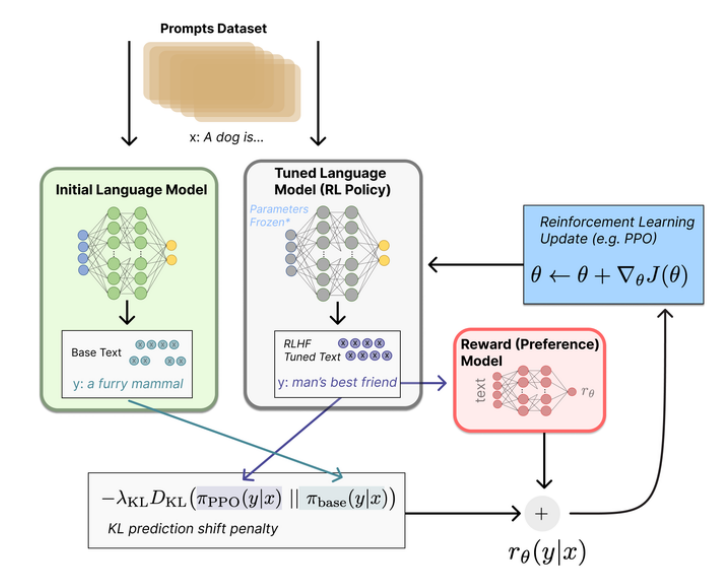

In [24]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=128
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

모델학습에 사용할 옵티마이저와 모델을 준비

In [25]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [26]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

PPO 학습에 쓸 데이터를 불러와 토크나이징

In [27]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [28]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [29]:
len(list_prompt)

12000

PPO는 별도의 PPOTrainer 클래스를 설계하여 학습시켜줘야 합니다.

In [68]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=5,  
                     train_batch_size=16, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

PPO의 loss function은 chatgpt/models 폴더 내의 loss.py 모듈에서 PolicyLoss와 ValueLoss 클래스에 정의되어 있음

참고링크 

https://gist.github.com/JoaoLages/c6f2dfd13d2484aa8bb0b2d567fbf093#3---fine-tuning-the-lm-with-rl

PolicyLoss클래스의 forward메서드에 있는 코드와 비교

허깅페이스에서 제공하는 Deep RL Course

https://huggingface.co/learn/deep-rl-course/unit8/introduction?fw=pt

### PPO 학습

In [29]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

Train epoch [1/5]: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, actor_loss=0, critic_loss=0.0145]

Train epoch [2/5]: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, actor_loss=0, critic_loss=0.525]

Train epoch [3/5]: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, actor_loss=0, critic_loss=0.0248]

Train epoch [4/5]: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, actor_loss=0, critic_loss=0.242]

Train epoch [1/5]: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, actor_loss=-.23, critic_loss=0.101]

Train epoch [2/5]: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, actor_loss=-.248, critic_loss=0.01]

Train epoch [3/5]: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, actor_loss=-.25, critic_loss=0.0297]

Train epoch [4/5]: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, actor_loss=-.25, critic_loss=0.0915]

Train epoch [1/5]: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, actor_loss=0.195, critic_loss=0.0791]

Train epoch [2/5]: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, actor_loss=0.231, criti

In [33]:
RM_model.save_pretrained('aiffel/KoChatGPT/output_3_PPO')

### RLHF 모델 정량적 평가 - BLEU Score

In [52]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=128,
                             do_sample=True,
                             top_k=50,
                             top_p=0.50,
                             no_repeat_ngram_size=4, 
                             early_stopping=True,
                             repetition_penalty=2.0,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]

    return output

data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file_SFT:
    list_data_dict_SFT = json.load(json_file_SFT)[11900:]

input_prompt = []
for i in list_data_dict_SFT:
    input_prompt.append(i['prompt'])
    
labeled_completion = []
for i in list_data_dict_SFT:
    labeled_completion.append(i['completion'])

In [53]:
RLHF_output = []
for input_text in input_prompt:
    RLHF_output.append(generation(input_text))

In [58]:
from datasets import load_metric

# Load the BLEU metric
metric = load_metric("sacrebleu")

# Function to tokenize a sentence
def tokenize_sentence(sentence):
    # Implement tokenization using your tokenizer
    # Return a list of tokens
    tokens = tokenizer.tokenize(sentence)
    return tokens

# Function to calculate BLEU score
def calculate_bleu_score(model_outputs, target_sentences):
    # Tokenize model outputs and target sentences
    tokenized_outputs = [tokenize_sentence(output) for output in model_outputs]
    tokenized_targets = [tokenize_sentence(target) for target in target_sentences]
    
    # Calculate BLEU score
    bleu_score = metric.compute(predictions=tokenized_outputs, references=tokenized_targets)
    
    return bleu_score

# Calculate BLEU score
RLHF_bleu_score = []
for output, target in zip(RLHF_output, labeled_completion):
    RLHF_bleu_score.append(calculate_bleu_score([output], [target])['score'])

/tmp/ipykernel_150/3689558111.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")
Token indices sequence length is longer than the specified maximum sequence length for this model (169 > 128). Running this sequence through the model will result in indexing errors


In [34]:
sum(RLHF_bleu_score)/len(RLHF_bleu_score)

0.1488411840332464

### 아래는 임의로 선택한 5개 prompt에 대한 SFT model의 답변과 RLHF model의 답변

In [64]:
# foundation model 과 SFT model 결과 비교 시 사용한 input prompt 사용
search_str = ['가출해도 갈 데가 없어', '어느 경우에 하드웨어에 직접 접근하는 도스 구조가 알맞아', 
              '그럼 두 조각에 그렇게죠?', '저거는 소가죽인가요?', '내일 체크아웃은 몇 시인가요?']

# 인덱스를 저장할 빈 리스트
indices = []

# 리스트 순회하면서 주어진 문자열이 있는지 확인하고 인덱스를 저장
for i, item in enumerate(input_prompt):
    if item in search_str:
        indices.append(i)

print(indices)

[24, 40, 67, 73, 98]


#### Input Prompts

In [65]:
for index in indices:
    print(input_prompt[index], '\n')

어느 경우에 하드웨어에 직접 접근하는 도스 구조가 알맞아 

저거는 소가죽인가요? 

그럼 두 조각에 그렇게죠? 

내일 체크아웃은 몇 시인가요? 

가출해도 갈 데가 없어 



#### SFT model의 답변

In [75]:
## 저장된 결과 붙여넣기

가출해도 갈 데가 없어요. 대신, 새로운 도전과 경험을 찾아보는 것도 좋을 것 같아요. 새로운 도전과 경험으로 더 나은 결과를 얻을 수 있을 거예요.", 'token': 47}</s> \n\n새로운 도전과 경험에 대한 평가는 개인적인 측면과 상황에 따라 다를 수 있지만, 일반적으로는 다음과 같은 것들이 도움이 될 수 있습니다.\n첫째, 실패를 경험하는 것은 매우 중요합니다. 실패는 많은 것을 야기합니다. 하지만 그것을 극복하는 방법은 다양합니다. 어떤 분야에서든 목표를 설정하고, 그 목표를 달성하기 위해 노력해야 합니다.\n둘째, 새로운 취미나 활동을 시도해 볼 수 있습니다. 새로운 취미를 찾아보는 것도 

어느 경우에 하드웨어에 직접 접근하는 도스 구조가 알맞아졌습니다. 이러한 방식은 전통적인 방식으로는 더 나은 응답을 제공하기 어렵습니다. 따라서 하드웨어에서 사용되는 하드웨어 구조에 대한 접근은 더욱 용이합니다. 예를 들어, 하드웨어 구조에 직접 접근하는 방법은 사용자가 원하는 대로 하드웨어 구조에 접근할 수 있는 반면, 하드웨어 구조에 접근하는 방식은 하드웨어 구조에 가장 적합한 방법을 선택해야 합니다. 예를 들어, 프로그래밍 언어에서는 일반적으로 하드웨어 구조에 접근하고 싶으면 다음과 같은 방법을 시도해 볼 수 있습니다.\n\n1. 하드웨어 구조 변경: 하드웨어 구조를 변경할 수 있습니다. 예를 들어, 사용자가 하드웨어 구조에 가상의 채팅창을 만들어 보세요.\n\ 

그럼 두 조각에 그렇게죠?\n\n그렇다면 그 안에 무엇이 들어있나요?\n저는 인공지능 어시스턴트이기 때문에 질문에 대한 답변만 가능합니다. 질문이 어떤 것인지 자세히 설명해주시면 더욱 정확한 답변을 드릴 수 있을 것 같습니다. 감사합니다.</s> 챗봇입니다.</s> "어디 있나요?" 또는 "네, 무엇을 도와드릴까요?"가 무엇인지 알려주시면 더 정확한 답변을 제공해 드릴 수 있습니다.</s> hellofty have information or specific response.</s> "어 


#### RLHF model의 답변

In [38]:
for index in indices:
    print(RLHF_output[index], '\n')

어느 경우에 하드웨어에 직접 접근하는 도스 구조가 알맞아졌는지 여부가 결정될 수 있습니다. 그러나 하드웨어에서의 성능이 향상된 경우에는 하드웨어에서의 성능이 향상된 경우가 많으며, 이러한 성능이 향상된 경우에는 하드웨어에서의 성능이 향상된 경우가 많습니다. 따라서 하드웨어에서의 성능이 향상된 경우에는 하드웨어에서의 성능이 향상된 경우가 많습니다. Errain, Ill since you please provide more disk or outcome about the sense offensive about which is it looks beau 

저거는 소가죽인가요?\n\n제가 알고 있는 정보로는, "소'가죽은 어떤 상황인지 명확하지 않습니다. 소가죽은 소가죽은 소가죽이 무엇인지 좀 더 구체적으로 설명해주시면 답변을 드릴 수 있을 것 같습니다.", 'token': 54} 다시 한번 더 자세한 정보를 제공해주시면 답변을 드릴 수 있을 것 같습니다. 소라는 동물이고, 그 외에도 다른 동물들이 있을 수 있습니다. 좀 더 자세한 정보를 제공해주시면 더 정확한 답변을 드릴 수 있을 것입니다. 다시 한번 더 자세한 정보를 알려주시면 답변을 드릴 수 있을 것 같습니다. 다시 한번 

그럼 두 조각에 그렇게죠? 두 조각에 손을 넣은 것 같습니다. 이게 어떤 의미인지 좀 더 구체적으로 설명해주시면 더 정확한 대답을 드릴 수 있을 것 같습니다. #'네, 어떤 조각으로 이루어졌는지 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. #) \'해당 문맥을 추가해주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. #'해당 조각\' 또는 '들어간 것 같습니다. \' 등으로 알려주시면 더 정확한 답변을 드릴 수 있을 것 같습니다. #) # 

내일 체크아웃은 몇 시인가요? 제가 답변을 드릴 수 없습니다. 어떤 맥락에서 체크아웃이 가능한지에 대한 정보가 제공되지 않았다면 죄송합니다. 좀 더 구체적인 내용을 알려주시면 답변을 드릴 수 있을 것 같습니다. 해당 호텔 또는 여행사 웹사

# Rubric 2. SFT 모델과 RLHF 모델 결과 분석

- 정량적 비교(Metric : Bleu)
1. SFT model 의 Bleu Score : 0.136
2. RLFM model 의 Bleu Score : 0.149
4. Bleu Score는 동일 단어 빈도에 따른 측정 방식을 가진다. foundation model 과 SFT model 모두 generated output에 input prompt가 포함되어 있기 때문에 평균적으로 약 0.12 가 넘는 bleu score를 나타냈다. 이러한 관점에 서 봤을 때 bleu score 는 foudation model 과 SFT model의 성능을 평가하는데 크게 유의미하지 않은 정량적 지표인 것으로 생각된다.

- 정성적 비교
1. 앞서 비교한 것과 같이 SFT model은 중간에 영어나 문맥에 맡지 않는 단어가 나오긴 하지만 전체적인 맥락이 질문자에게 질문에 대한 답을 이어나가는 모습을 보였다.
2. RLHF 모델은 SFT model과 같이 질문자에게 답변하는 형식이 명확했다. 중복되는 단어나 내용이 눈에 띄지만, 전체적인 맥락을 볼 때 질문에 대한 답변을 뚜렷하게 한다는 것을 느꼈다.
3. RM 모델을 훈련할 때 5000개 훈련셋과 1000개 검증셋을 활용했을 때 한자나 영문을 생성하는 빈도가 잦아들었다.

# 3. Foundation Model 교체를 통한 정량적 성능향상

사용 모델 : monologg/koelectra-base-v3-finetuned-korquad

https://huggingface.co/monologg/koelectra-base-v3-finetuned-korquad

In [9]:
import pandas as pd
import numpy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = 'monologg/koelectra-base-v3-finetuned-korquad'
foundation_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                           bos_token='</s>', 
                                           eos_token='</s>', 
                                           unk_token='</s>', 
                                           pad_token='</s>',
                                           padding_side="right",
                                           model_max_length=128,
                                          )

If you want to use `ElectraForCausalLM` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at monologg/koelectra-base-v3-finetuned-korquad were not used when initializing ElectraForCausalLM: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing ElectraForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForCausalLM were not initialized from the model checkpoint at monologg/koelectra-base-v3-finetuned-korquad and are newly initialized: ['generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'gene

### 정량적, 정성적 평가 비교 분석 시 사용할 데이터셋(n=100) 준비

In [10]:
data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file_SFT:
    list_data_dict_SFT = json.load(json_file_SFT)[11900:]

print(len(list_data_dict_SFT))

100


In [11]:
input_prompt = []
for i in list_data_dict_SFT:
    input_prompt.append(i['prompt'])
    
labeled_completion = []
for i in list_data_dict_SFT:
    labeled_completion.append(i['completion'])

### 새로운 foundation_model 이 input_prompt 을 입력으로 받아 생성한 foundation_output 저장

In [12]:
foundation_output = []
max_length = 128

for input_txt in input_prompt:
    input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
    output= foundation_model.generate(input_ids, max_length=max_length, num_beams=4, no_repeat_ngram_size=4, early_stopping=True,
                                 eos_token_id=375, do_sample=True, top_k=50, repetition_penalty=2.0)
    foundation_output.append(tokenizer.decode(output[0]))

### 새로운 foundation_output 에 빈 데이터('')가 있는지 확인

In [13]:
output_answers_empty_indices = []
for i, item in enumerate(foundation_output):
    if item == '':
        output_answers_empty_indices.append(i)

print(output_answers_empty_indices)

[]


### 정량적 평가 - BLEU metric을 활용

In [14]:
from datasets import load_metric

# Load the BLEU metric
metric = load_metric("sacrebleu")

# Function to tokenize a sentence
def tokenize_sentence(sentence):
    # Implement tokenization using your tokenizer
    # Return a list of tokens
    tokens = tokenizer.tokenize(sentence)
    return tokens

# Function to calculate BLEU score
def calculate_bleu_score(model_outputs, target_sentences):
    # Tokenize model outputs and target sentences
    tokenized_outputs = [tokenize_sentence(output) for output in model_outputs]
    tokenized_targets = [tokenize_sentence(target) for target in target_sentences]
    
    # Calculate BLEU score
    bleu_score = metric.compute(predictions=tokenized_outputs, references=tokenized_targets)
    
    return bleu_score

# Calculate BLEU score
foundation_bleu_score = []
for output, target in zip(foundation_output, labeled_completion):
    foundation_bleu_score.append(calculate_bleu_score([output], [target])['score'])

Token indices sequence length is longer than the specified maximum sequence length for this model (130 > 128). Running this sequence through the model will result in indexing errors


### 새로운 foundation model 의 BLEU Score

In [15]:
sum(foundation_bleu_score)/len(foundation_bleu_score)

0.233327279313539

## Rubric 3. 데이터셋 정제 / 새로운 데이터셋 / foundation model 교체 중 하나를 이용해 정량적 성능 향상을 해보았는가?

: 'monologg/koelectra-base-v3-finetuned-korquad' QA 태스크에 특화된 pre-trained 모델을 foundation model로 활용하여 정량적 지표 - Bleu Score - 에서 향상을 이뤄냈다. 이전 'skt/kogpt2-base-v2' 모델의 최고 Bleu Score는 0.2 였고, 새로운 trained-model의 Bleu Score는 0.233로 약 15% 정량적 성능 향상을 나타냈다.

# 회고

- 배운 점
1. LLM 모델의 transfer learning을 직접 구현할 수 있었다.
2. 강화 학습의 원리를 이해할 수 있었고, 간접적이게 나마 구현할 수 있었다.
3. 챗GPT 3.5버전의 원리를 이해할 수 있었다.

- 문제해결을 시도한 점
1. evaluation 단계에서 OOM 문제가 지속적이게 발생하였다. 그래서 transformers 라이브러리가 아닌 for 문으로 직접 generated text를 가지고 metrix 함수를 구현하여 정량적 평가 결과를 구해냈다.
2. SFT 데이터셋에 공백 데이터가 있는 경우, 정량적 평가 시 오류가 발생하였다. 데이터셋의 공백이 있는 인덱스를 찾아내어 제거하는 함수를 활용해서 결측치 문제를 해결하였다.
3. OOM 문제 해결을 위해 max token length를 조절해가며 메모리 한계에 맞춰 학습을 진행할 수 있었다.
4. 정량적 평가를 구현하는 과정에서 많은 오류가 발생하였다. BLEU의 원리와 코드 자료를 확인해 가면서 정확한 데이터 입력 형태와 출력 형태를 파악하고, 최종적인 평균값을 구하여 정량적 평가 지표를 완성하였다.

- 아쉬운 점
1. jsonl 파일을 판다스 데이터프레임으로 불러올 수 있다는 사실을 다른 분들과 얘기하면서 알게 되었다. 데이터셋에 공백 데이터가 포함되는 등 복잡한 문제가 있어서 json 형식의 파일로 전처리하기 어려웠는데, 판다스 데이터프레임으로 활용할 수 있다면 전처리를 통한 성능향상을 시도할 수 있었을 것이다.
2. 처음에 transformers 라이브러리에서 data collator, data loader 와 같은 함수를 이해하는데 시간을 많이 소비한 것 같다. 한편 이 속에서 데이터의 입력과 출력 과정을 일일이 확인해 가면서 코드를 이해하는 시간이 되었다.
3. PPO model이 initial model로부터 지나치게 벗어나지 않도록 설계한 구조가 수학적으로 이해되지 않았다. 추가적인 공부를 통해 원리를 이해하고자 한다.